In [2]:
import os, sys, json, random
import pandas as pd
import numpy as np

from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt

import dcor

import xgboost as xgb

# scikit-learn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
BASEDIRECTORY = "/Users/phillip/Sync/MIMIC III Uncompressed Datasets"

In [ ]:
#  Possible feature names in D_ITMES.csv
features_list = [
    "Heart Rate",
    "O2 saturation pulseoxymetry",
    "Temperature Celsius",
    "Temperature C",
    "Temperature C (calc)",
    "Arterial Blood Pressure systolic",
    "ABP [Systolic]",
    "Arterial BP [Systolic]",
    "Arterial Blood Pressure diastolic",
    "ABP [Diastolic]",
    "Arterial BP [Diastolic]",
    "Arterial Blood Pressure mean",
    "Arterial BP Mean",
    "Respiratory Rate (Total)",
    "Respiratory Rate",
    "EtCO2",
    "Base Excess",
    "HCO3",
    "FIO2",
    "FiO2" "Inspired O2 Fraction",
    "ph level",
    "PH",
    "Ph",
    "Arterial PaCO2",
    "Arterial O2 Saturation",
    "SaO2",
    "Alkaline Phosphatase",
    "Alkaline Phosphate",
    "Calcium",
    "Chloride (whole blood)",
    "Chloride",
    "Creatinine",
    "Direct Bilirubin",
    "Glucose (serum)",
    "Lactic Acid",
    "Magnesium",
    "Potassium",
    "Troponin",
    "Hematocrit",
    "Hemoglobin",
    "PTT",
    "Ptt",
    "WBC",
    "FIBRINOGEN",
    "Fibrinogen",
    "Platelets",
    "Present Weight  (kg)",
    "Weight Kg",
]

In [3]:
d_items_df = pd.read_csv("{}/{}".format(BASEDIRECTORY, "D_ITEMS.csv"))
diagnose_df = pd.read_csv("{}/{}".format(BASEDIRECTORY, "DIAGNOSES_ICD.csv"))
d_icd_diagnose_df = pd.read_csv("{}/{}".format(BASEDIRECTORY, "D_ICD_DIAGNOSES.csv"))
admission_df = pd.read_csv("{}/{}".format(BASEDIRECTORY, "ADMISSIONS.csv"))
patient_df = pd.read_csv("{}/{}".format(BASEDIRECTORY, "PATIENTS.csv"))

NameError: name 'BASEDIRECTORY' is not defined

In [5]:
selected_itemids_df = d_items_df[
    d_items_df.LABEL.isin(features_list) & (d_items_df.LINKSTO == "chartevents")
][["ITEMID", "LABEL"]]

In [6]:
# 找出sepsis相关的ICD码
sepsis_icd = d_icd_diagnose_df[
    d_icd_diagnose_df.SHORT_TITLE.str.contains("sepsis|septic")
]
sepsis_icd

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
69,242,0031,Salmonella septicemia,Salmonella septicemia
542,593,0545,Herpetic septicemia,Herpetic septicemia
595,646,0380,Streptococcal septicemia,Streptococcal septicemia
596,647,03810,Staphylcocc septicem NOS,"Staphylococcal septicemia, unspecified"
598,649,03812,MRSA septicemia,Methicillin resistant Staphylococcus aureus se...
599,650,03819,Staphylcocc septicem NEC,Other staphylococcal septicemia
600,651,0382,Pneumococcal septicemia,Pneumococcal septicemia [Streptococcus pneumon...
601,652,0383,Anaerobic septicemia,Septicemia due to anaerobes
602,653,03840,Gram-neg septicemia NOS,"Septicemia due to gram-negative organism, unsp..."
603,654,03841,H. influenae septicemia,Septicemia due to hemophilus influenzae [H. in...


In [7]:
selected_ICD9 = ["99592", "77181"]

In [267]:
# select useful variables from chartevents.csv
# not necessary to call every time
# can load from file

# selected_itemids_series = selected_itemids_df.ITEMID
# selected_chartevents_df = pd.DataFrame()
# with pd.read_csv(
#     "{}/{}".format(BASEDIRECTORY, "CHARTEVENTS.csv"),
#     usecols=[
#         "SUBJECT_ID",
#         "HADM_ID",
#         "ICUSTAY_ID",
#         "ITEMID",
#         "CHARTTIME",
#         "STORETIME",
#         "VALUENUM",
#     ],
#     chunksize=10000000,
#     low_memory=False,
# ) as chartevents_reader:
#     for chunk in chartevents_reader:
#         selected_chartevents_df = pd.concat(
#             [
#                 selected_chartevents_df,
#                 chunk[chunk.ITEMID.isin(selected_itemids_series)],
#             ],
#             ignore_index=True,
#         )

# selected_chartevents_df.drop(
#     columns=[
#         "ROW_ID",
#         "HADM_ID",
#         "CGID",
#         "VALUE",
#         "VALUEUOM",
#         "WARNING",
#         "ERROR",
#         "RESULTSTATUS",
#         "STOPPED",
#     ],
#     inplace=True,
# )

In [268]:
# selected_chartevents_df.to_csv("selected_chartevents.csv")

In [8]:
selected_chartevents_df = pd.read_csv("selected_chartevents.csv")

In [9]:
selected_admissionID_series = selected_chartevents_df.HADM_ID.drop_duplicates()
selected_subjectID_series = selected_chartevents_df.SUBJECT_ID.drop_duplicates()
# print(len(selected_admissionID_series), len(selected_subjectID_series))

In [270]:
selected_chartevents_df.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,VALUENUM
0,36,165660,241249.0,225668,2134-05-12 12:35:00,2134-05-12 12:38:00,1.0
1,36,165660,241249.0,220045,2134-05-12 13:00:00,2134-05-12 13:55:00,86.0
2,36,165660,241249.0,220210,2134-05-12 13:00:00,2134-05-12 13:55:00,21.0
3,36,165660,241249.0,220277,2134-05-12 13:00:00,2134-05-12 13:55:00,93.0
4,36,165660,241249.0,220045,2134-05-12 14:00:00,2134-05-12 14:39:00,85.0


In [10]:
grouped = (
    selected_chartevents_df.groupby("HADM_ID")
    .apply(lambda x: x.sort_values("CHARTTIME"))
    .reset_index(drop=True)
)

In [10]:
grouped.head()

,Unnamed: 0,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,VALUENUM
0,5823576,58526,100001,275225.0,220210,2117-09-11 12:57:00,2117-09-11 13:00:00,14.0
1,5823575,58526,100001,275225.0,220045,2117-09-11 12:57:00,2117-09-11 13:00:00,122.0
2,5823578,58526,100001,275225.0,220210,2117-09-11 13:00:00,2117-09-11 18:13:00,22.0
3,5823577,58526,100001,275225.0,220045,2117-09-11 13:00:00,2117-09-11 18:13:00,118.0
4,5823580,58526,100001,275225.0,220210,2117-09-11 13:50:00,2117-09-11 13:00:00,22.0


In [11]:
g = grouped.groupby("HADM_ID")

In [12]:
def combineColumns(
    df: "target dataframe",
    columns_list: "list of column names",
    newColumn: "name of merged column",
) -> "pd.series":
    real_list = list(filter(lambda x: x in df.columns, columns_list))
    #     print(real_list)
    if real_list:
        n_notNA_series = df[real_list].shape[1] - df[real_list].isna().sum(axis=1)
        ret = (
            df[real_list]
            .fillna(0)
            .sum(axis=1)
            .replace(0, np.nan)
            .divide(n_notNA_series)
        )
        df.drop(columns=real_list, inplace=True)
        df[newColumn] = ret

In [13]:
# 合并相同的含义的列
def merge(df):
    combineColumns(
        df,
        ["Temperature Celsius", "Temperature C", "Temperature C (calc)"],
        "Temperature",
    )
    combineColumns(
        df,
        [
            "ABP [Systolic]",
            "Arterial BP [Systolic]",
            "Arterial Blood Pressure systolic",
        ],
        "ABP-S",
    )
    combineColumns(
        df,
        [
            "ABP [Diastolic]",
            "Arterial BP [Diastolic]",
            "Arterial Blood Pressure diastolic",
        ],
        "ABP-D",
    )
    combineColumns(df, ["Arterial BP Mean", "Arterial Blood Pressure mean"], "ABP-M")
    combineColumns(df, ["Respiratory Rate", "Respiratory Rate (Total)"], "RR")
    combineColumns(
        df, ["ph level", "PH", "Ph",], "PH",
    )
    combineColumns(df, ["Present Weight  (kg)", "Weight Kg",], "weight")
    combineColumns(
        df, ["Arterial O2 Saturation", "O2 saturation pulseoxymetry", "SaO2"], "SaO2"
    )
    duplicated_columns = df.columns[df.columns.duplicated()]
    for c in duplicated_columns:
        combineColumns(df, [c], c)

In [355]:
x = g.get_group(187556)[["ITEMID", "CHARTTIME", "VALUENUM"]]
print(len(x), len(x.drop_duplicates()))
print(x.drop_duplicates())
# print(x.drop_duplicates().pivot(index="CHARTTIME", columns="ITEMID", values="VALUENUM"))

307 304
          ITEMID            CHARTTIME    VALUENUM
30042149     211  2192-11-12 19:45:00   71.000000
30042150     618  2192-11-12 19:45:00   21.000000
30042151     677  2192-11-12 20:00:00   35.888901
30042152     618  2192-11-12 20:00:00   15.000000
30042153     211  2192-11-12 20:00:00   64.000000
...          ...                  ...         ...
30042451     618  2192-11-14 12:00:00   26.000000
30042452     211  2192-11-14 12:00:00  100.000000
30042453     211  2192-11-14 13:00:00   90.000000
30042454     677  2192-11-14 13:00:00   36.333302
30042455     618  2192-11-14 13:00:00   26.000000

[304 rows x 3 columns]


In [345]:
# test
# 忽略这个cell
t = g.get_group(187556).pivot(index="CHARTTIME", columns="ITEMID", values="VALUENUM")
t.columns = list(
    map(
        lambda x: str(x).replace(
            str(x), selected_itemids_df.LABEL[selected_itemids_df.ITEMID == x].iloc[0],
        ),
        t.columns,
    )
)
t.reset_index(inplace=True)
print(t.head())
print(t.shape)
merge(t)
print(t.shape)

ValueError: Index contains duplicate entries, cannot reshape

In [323]:
a = pd.to_datetime(admission_df[admission_df.HADM_ID == 144319].ADMITTIME)
print(a)
sid = admission_df[admission_df.HADM_ID == 144319].SUBJECT_ID.values[0]
print(sid)
b = pd.to_datetime(patient_df[patient_df.SUBJECT_ID == sid].DOB.values[0])
print(b.year)
print((pd.to_datetime(t.CHARTTIME) - b))
# t["AGE"] = (pd.to_datetime(t.CHARTTIME) - b) / pd.Timedelta(1, "D")

13   2191-02-23 05:23:00
Name: ADMITTIME, dtype: datetime64[ns]
34
1886


OverflowError: Overflow in int64 addition

In [311]:
t.head()

,CHARTTIME,Creatinine,Glucose (serum),RR,HR,SaO2,Magnesium,WBC,Hemoglobin,AGE
0,2117-09-11 12:57:00,NaN,NaN,14.0,122.0,NaN,NaN,NaN,NaN,12839.539583
1,2117-09-11 13:00:00,NaN,NaN,22.0,118.0,NaN,NaN,NaN,NaN,12839.541667
2,2117-09-11 13:50:00,NaN,NaN,22.0,118.0,NaN,NaN,NaN,NaN,12839.576389
3,2117-09-11 14:00:00,NaN,NaN,15.0,118.0,NaN,NaN,NaN,NaN,12839.583333
4,2117-09-11 15:00:00,NaN,NaN,15.0,110.0,NaN,NaN,NaN,NaN,12839.625000


In [339]:
cc1 = 0
cc2 = 0
for df in df_list:
    if df.LABEL[0] == 1:
        cc1 += 1
    elif df.LABEL[0] == 2:
        cc2 += 1
print(cc1, cc2)

2659 46


In [343]:
selected_admissionID_series.iloc[len(df_list)]

187556

In [14]:
df_list = []
c = 0
for admission_id in selected_admissionID_series:
    #         print(admission_id)
    try:
        temp = (
            g.get_group(admission_id)[["CHARTTIME", "ITEMID", "VALUENUM"]]
            .drop_duplicates()
            .pivot(index="CHARTTIME", columns="ITEMID", values="VALUENUM")
        )
    except ValueError:
        continue
    temp.columns = list(
        map(
            lambda x: str(x).replace(
                str(x),
                selected_itemids_df.LABEL[selected_itemids_df.ITEMID == x].iloc[0],
            ),
            temp.columns,
        )
    )
    #     print(patientid)
    temp.reset_index(inplace=True)
    merge(temp)
    # 加入静态的变量
    # get SUBJECT_ID first
    sub_id = admission_df[admission_df.HADM_ID == admission_id].SUBJECT_ID.values[0]
    # gender
    temp["GENDER"] = patient_df[patient_df.SUBJECT_ID == sub_id].GENDER.values[0]
    # age
    dob = pd.to_datetime(patient_df[patient_df.SUBJECT_ID == sub_id].DOB.values[0])
    # 小于1990年代表年龄大于等于90，一律按90岁算
    if dob.year < 1990:
        temp["AGE"] = 32850
    else:
        temp["AGE"] = (pd.to_datetime(temp.CHARTTIME) - dob) / pd.Timedelta(1, "D")
    # ICULOS
    doa = pd.to_datetime(
        admission_df[admission_df.HADM_ID == admission_id].ADMITTIME.values[0]
    )
    temp["ICULOS"] = (pd.to_datetime(temp.CHARTTIME) - doa) / pd.Timedelta(1, "hour")
    # 加入结果标签
    if (
        diagnose_df[diagnose_df.HADM_ID == admission_id].ICD9_CODE == selected_ICD9[0]
    ).sum() > 0:
        temp["LABEL"] = 1
    elif (
        diagnose_df[diagnose_df.HADM_ID == admission_id].ICD9_CODE == selected_ICD9[1]
    ).sum() > 0:
        temp["LABEL"] = 2
    else:
        temp["LABEL"] = 0
    # 把处理好的每一个dataframe加入到df_list列表中
    df_list.append(temp)
    if c % 10000 == 0:
        print(c)
    c += 1
#     sys.exit(1)

0
10000
20000
30000
40000
50000


In [25]:
len(list(filter(lambda x: x.LABEL[0] == 0, df_list)))
len(df_list)

52785

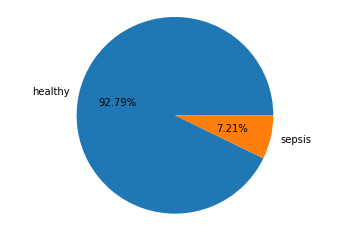

In [29]:
labels = ["healthy", "sepsis"]
sizes = [52785, 4099]
colors = ["tab:blue", "tab:orange"]
plt.pie(sizes, labels=labels, colors=colors, autopct="%3.2f%%", shadow=False)
plt.axis("equal")
plt.savefig("ratio_of_MIMIC.png")

In [ ]:
selected_admissions_df = admission_df[
    admission_df.SUBJECT_ID.isin(selected_patientid_series)
][["SUBJECT_ID", "ADMITTIME"]]

In [ ]:
selected_patients_df = patient_df[
    patient_df.SUBJECT_ID.isin(selected_patientid_series)
]["SUBJECT_ID", "GENDER", "DOB"]

In [44]:
# 检查还有没有重复的columns
for df in df_list:
    if df.columns.has_duplicates:
        print(df.columns)
        break

In [15]:
# 求方差，correlation，和tree-based feature selection
merged_df = pd.concat(df_list, ignore_index=True, axis=0)

In [16]:
# scale first
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(
    scaler.fit_transform(
        merged_df[merged_df.columns.difference(["CHARTTIME", "GENDER"])]
    ),
    columns=merged_df.columns.drop(["CHARTTIME", "GENDER"]),
)

In [17]:
v = scaled_df.var()

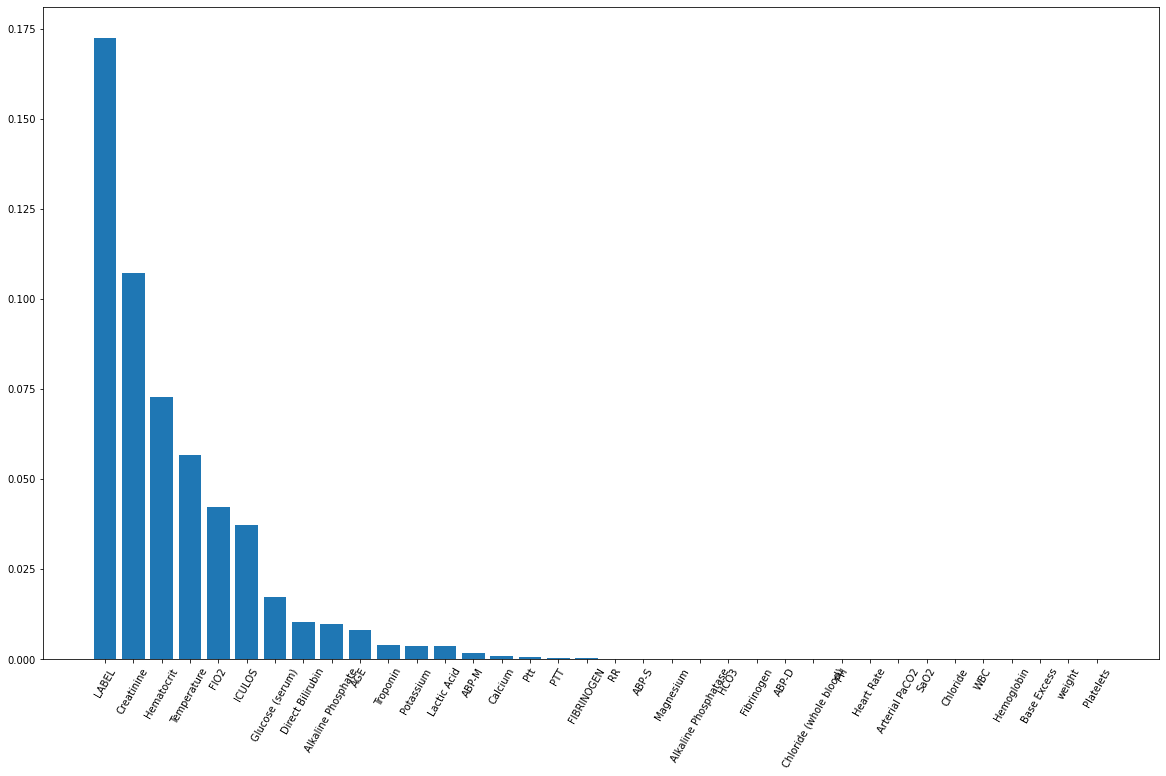

In [22]:
# variance threshold
# v = v.drop(["LABEL"])
plt.figure(figsize=(20, 12))
plt.bar(v.sort_values(ascending=False).index, v.sort_values(ascending=False))
plt.xticks(rotation=60)
plt.savefig("variance_MIMIC_data.png")
plt.show()

In [19]:
missing_ratio = (1 - merged_df.isna().sum() / merged_df.shape[0]).sort_values()

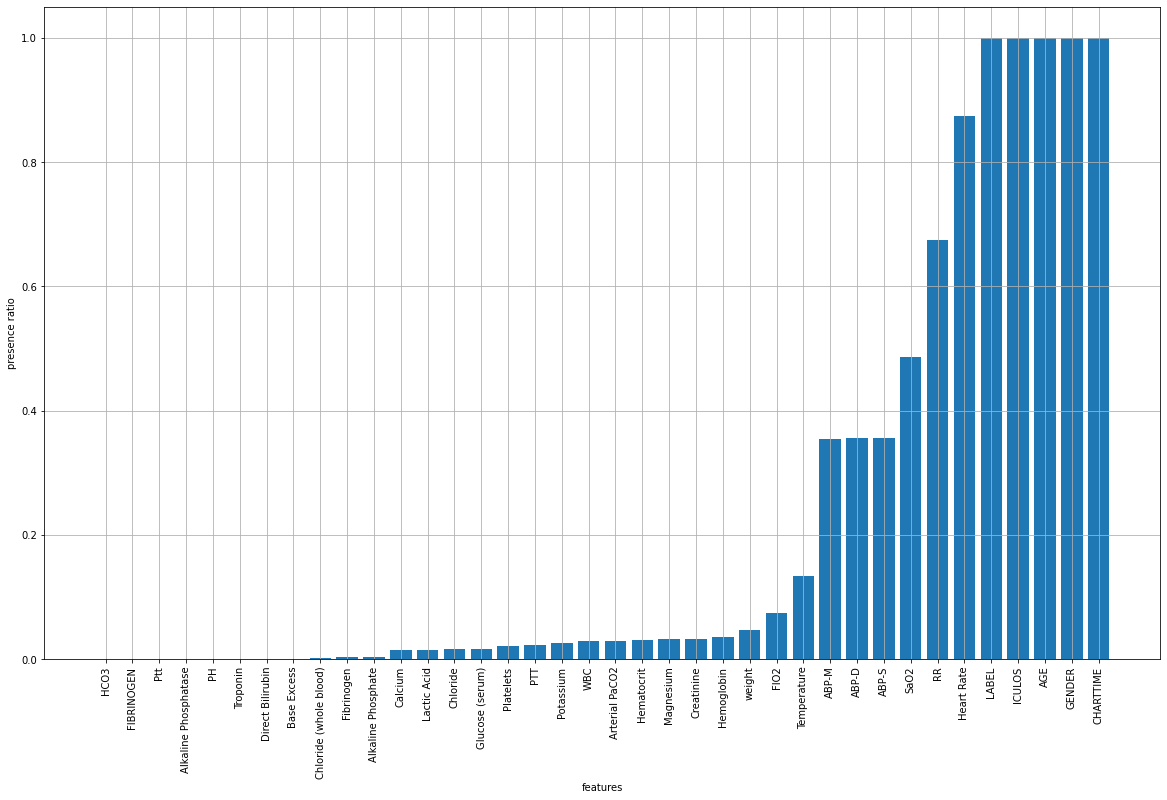

In [23]:
import matplotlib.pyplot as plt

missing_ratio = missing_ratio.drop(columns=["LABEL"])
plt.figure(figsize=(20, 12))
plt.bar(missing_ratio.sort_values().index, missing_ratio.sort_values())
plt.xticks(rotation=90)
plt.grid()
plt.ylabel("presence ratio")
plt.xlabel("features")
plt.savefig("presence_ratio_MIMIC.png")
plt.show()

In [77]:
# pearson correlation coefficeint
kept_features = ["AGE", "ICULOS", "Heart Rate", "RR", "SaO2", "ABP-S", "ABP-D", "ABP-M"]
ppc_matrix = pd.DataFrame(
    np.zeros([len(kept_features), len(kept_features)]),
    index=kept_features,
    columns=kept_features,
)
pvalue_matrix = pd.DataFrame(
    np.zeros([len(kept_features), len(kept_features)]),
    index=kept_features,
    columns=kept_features,
)
for i in range(len(kept_features)):
    for j in range(len(kept_features)):
        pair = merged_df[[kept_features[i], kept_features[j]]].dropna()
        #         print(pair[kept_features[i]])
        ppc = pearsonr(pair.iloc[:, 0].values, pair.iloc[:, 1].values)
        ppc_matrix.iloc[i][j] = ppc[0]
        pvalue_matrix.iloc[i][j] = ppc[1]

In [80]:
ppc_matrix.round(decimals=4).to_csv("ppc_matrix_MIMIC.csv")
pvalue_matrix.round(decimals=4).to_csv("pvalue_matrix_MIMIC.csv")

In [83]:
# Distance correlation coefficient
dcc_matrix = pd.DataFrame(
    np.zeros([len(kept_features), len(kept_features)]),
    index=kept_features,
    columns=kept_features,
)
for i in range(len(kept_features)):
    for j in range(len(kept_features)):
        pair = merged_df[[kept_features[i], kept_features[j]]].dropna()
        #         print(pair[kept_features[i]])
        dcc = dcor.distance_correlation(pair.iloc[:, 0].values, pair.iloc[:, 1].values)
        dcc_matrix.iloc[i][j] = dcc

In [84]:
dcc_matrix

,AGE,ICULOS,Heart Rate,RR,SaO2,ABP-S,ABP-D,ABP-M
AGE,1.000000,0.326051,0.792411,0.042452,0.016688,0.022818,0.295908,0.156372
ICULOS,0.326051,1.000000,0.373860,0.151258,0.022605,0.048901,0.036819,0.035109
Heart Rate,0.792411,0.373860,1.000000,0.242529,0.050542,0.066834,0.196687,0.088735
RR,0.042452,0.151258,0.242529,1.000000,0.059998,0.057291,0.055631,0.059011
SaO2,0.016688,0.022605,0.050542,0.059998,1.000000,0.034657,0.020137,0.037867
ABP-S,0.022818,0.048901,0.066834,0.057291,0.034657,1.000000,0.540051,0.785613
ABP-D,0.295908,0.036819,0.196687,0.055631,0.020137,0.540051,1.000000,0.871209
ABP-M,0.156372,0.035109,0.088735,0.059011,0.037867,0.785613,0.871209,1.000000


In [86]:
dcc_matrix.round(decimals=4).to_csv("dcc_mimic.csv")

In [106]:
# tree-based feature selection

df_normal = merged_df[merged_df.LABEL == 0].drop(columns=["GENDER", "CHARTTIME"])
df_sepsis = merged_df[merged_df.LABEL != 0].drop(columns=["GENDER", "CHARTTIME"])

df_normal.LABEL[df_normal.LABEL > 0] = 1
df_sepsis.LABEL[df_sepsis.LABEL > 0] = 1

sample_index = random.sample(range(len(df_normal)), len(df_sepsis))
df_normal = df_normal.iloc[sample_index, :]


# Create test set
X_train, X_test, y_train, y_test = train_test_split(
    pd.concat(
        [df_normal.drop(columns="LABEL"), df_sepsis.drop(columns="LABEL")], axis=0,
    ),
    pd.concat([df_normal["LABEL"], df_sepsis["LABEL"]], axis=0,),
    test_size=0.2,
)

# Create training set and validation set
# the ratio is training:validation:test = 6:2:2
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

/Users/yifeihu/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yifeihu/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [105]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1928244, 35) (1928244,)
(642749, 35) (642749,)
(642749, 35) (642749,)


In [107]:
# convert to DMatrix format used in xgboost
dtrain = xgb.DMatrix(X_train, label=y_train, silent=True)
dtest = xgb.DMatrix(X_test, label=y_test, silent=True)

# set initial training parameters
num_round = 500
cv_folds = 5
early_stopping_rounds = 50

# the switch to control whether we do cross validation to determine the best value of parameter "n_estimators"
# if you set it to True please change the value of "num_round" above to a lager number e.g. 10000
isCV = False

# if your computer does not support CUDA, please remove the parameter "tree_method" and "gpu_id"
clf = xgb.XGBClassifier(
    n_estimators=num_round,
    learning_rate=0.3,
    subsample=0.8,
    early_stopping_rounds=early_stopping_rounds,
    #     tree_method="gpu_hist",
    gamma=0.2,
    #     gpu_id=0,
    seed=0,
    nthread=4,
    silent=False,
)

if isCV:
    params = clf.get_params()
    cv_result = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=clf.get_params()["n_estimators"],
        nfold=cv_folds,
        metrics="auc",
        early_stopping_rounds=50,
        verbose_eval=100,
    )
    clf.set_params(n_estimators=cv_result.shape[0])

clf.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_val, y_val)],
    eval_metric=["auc", "error"],
    verbose=False,
)

# prediction with training set
train_preds_prob = clf.predict(X_train)
train_preds = [round(value) for value in train_preds_prob]
print("Accuracy (train): %.4g" % metrics.accuracy_score(y_train, train_preds))
print("AUC (train): %f" % metrics.roc_auc_score(y_train, train_preds_prob))

# prediction with test set
test_preds_prob = clf.predict(X_test)
test_preds = [round(value) for value in test_preds_prob]
print("Accuracy (test): %.4g" % metrics.accuracy_score(y_test, test_preds))
print("AUC (test): %f" % metrics.roc_auc_score(y_test, test_preds_prob))

/Users/yifeihu/opt/anaconda3/envs/dev/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:45:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { early_stopping_rounds, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy (train): 0.7976
AUC (train): 0.797625
Accuracy (test): 0.7875
AUC (test): 0.787440


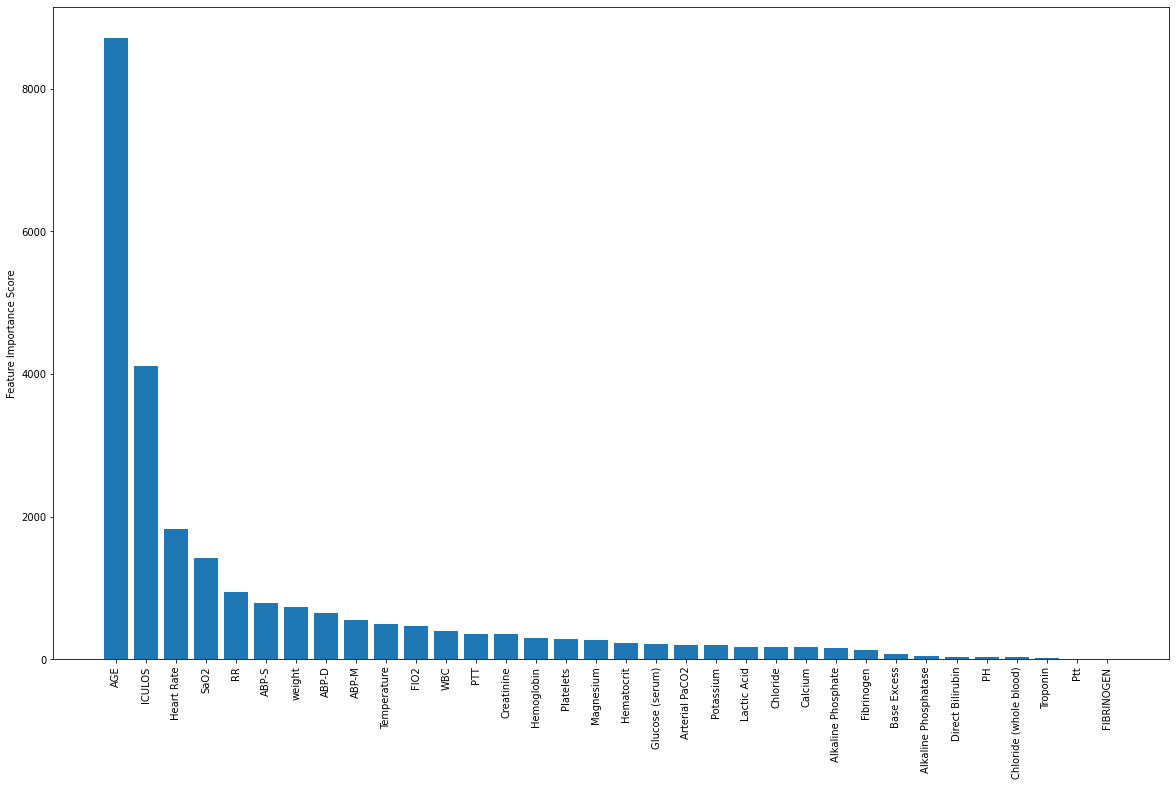

In [109]:
# print out feature importance
feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)
plt.figure(figsize=(20, 12))
plt.bar(feat_imp.index, feat_imp)
plt.xticks(rotation=90)
plt.ylabel("Feature Importance Score")
plt.savefig("feature_importance_xgboost_mimic.png")